In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from fastai.vision import *
from pathlib import Path
import pdb
import re
import seaborn as sns
from IPython.display import SVG, display
from wand.image import Image as WImage
import wand
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# enter your path here
path = Path("../google-fonts-data")

In [4]:
out = []
for file in progress_bar(path.glob("**/*.svg"),total=113646):
    try:
        s = file.open().read()
        match = re.match(".*viewBox=\"0 0 (\d+) (\d+)\".*<path.*d=\"([^\"]*)\".*",s,flags=re.DOTALL)
        match2 = re.match(".*<g transform=\"matrix\(1 0 0 -1 0 (\d+)\)\">.*",s,flags=re.DOTALL)
        xform = 0
        if match2:
            xform = float(match2.group(1))
        out.append({"file": file, "path": match.group(3), "box_x": float(match.group(1)), "box_y": float(match.group(2)),"xform": xform})
    except:
        pass

In [5]:
svgDF = pd.DataFrame(out)
svgDF["png"] = svgDF.file.apply(lambda f: "/".join(f.parts[:-2]) + "/png/" + f.name[:-3] + "png")
exists = svgDF.png.apply(lambda f: Path(f).exists())
svgDF["label"] = svgDF.file.apply(lambda f: f.name[:-4])
svgDF["font"] = svgDF.file.apply(lambda f: f.parts[4])
svgDF = svgDF[exists]
svgDF.head()

,box_x,box_y,file,path,xform,png,label,font
0,535.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M32 34q0 10 1 16l2 17q3 27 11.5 38.5t24.5 11.5...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,one,asap
1,843.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M57 6.5q-13 8.5 -11 28.5l66 635q3 32 63 32h52q...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,$M,asap
2,489.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M15.5 24.5q-8.5 24.5 -8.5 48.5q0 15 8 24l257 3...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,z,asap
3,731.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M493.5 -105.5q-133.5 56.5 -258.5 112.5q-97 44 ...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,$Q,asap
4,549.0,1000.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,M174 35l56 534h-158q-14 0 -20.5 9.5t-6.5 31.5q...,800.0,../google-fonts-data/italic/SANS_SERIF/asap/70...,$T,asap


In [6]:
def render_path(path,bbox_x,bbox_y):
    bbox_x,bbox_y = int(bbox_x),int(bbox_y)
    st = f'<svg viewBox="0 0 {bbox_x} {bbox_y}" xmlns="http://www.w3.org/2000/svg"><path d="{path}"/></svg>'
#     img = WImage(blob=str.encode(st),format="svg",width=128,height=128)
    return st

In [355]:
def render_path_wand(path,bbox_x,bbox_y):
    bbox_x,bbox_y = int(bbox_x),int(bbox_y)
    st = f'<svg viewBox="0 0 {bbox_x} {bbox_y}" xmlns="http://www.w3.org/2000/svg"><path d="{path}"/></svg>'
    img = WImage(blob=str.encode(st),format="svg",width=128,height=128)
    return img

In [7]:
svg_str = render_path(r.path,r.box_x,r.box_y)
print(svg_str)

NameError: name 'r' is not defined

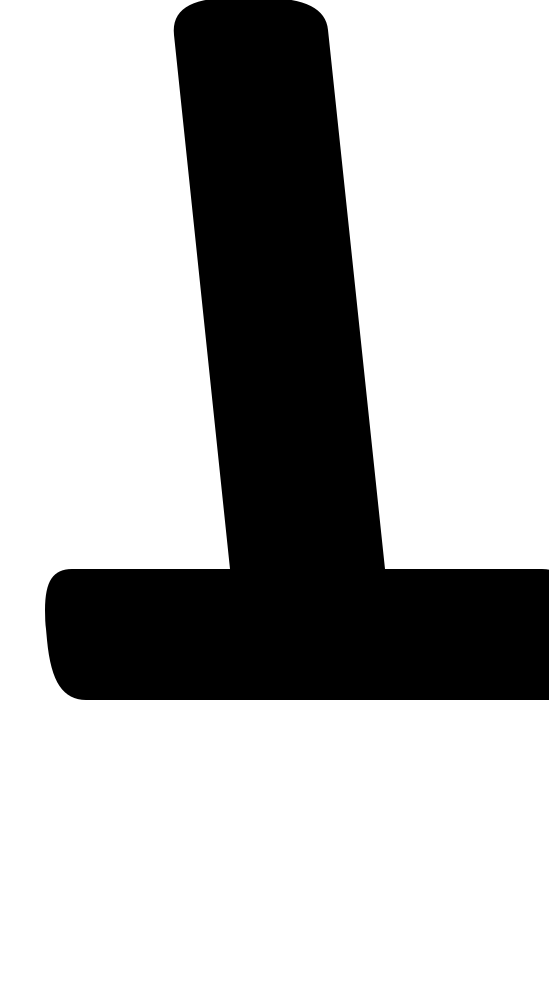

In [10]:
r = svgDF.iloc[4]
display(SVG(svg_str))

In [11]:
r['file']

PosixPath('../google-fonts-data/italic/SANS_SERIF/asap/700/svg/$T.svg')

In [8]:
tool_dict = {"P": [], "M": ["x","y"], "m": ["x","y"], "L": ["x","y"], "l": ["x","y"], "H": ["x"], "h": ["x"], 
             "V": ["y"], "v": ["y"], "C": ["x","y","x","y","x","y"], "c": ["x","y","x","y","x","y"], "S": ["x","y","x","y"], 
             "s": ["x","y","x","y"], "Q": ["x","y","x","y"], "q": ["x","y","x","y"], "T": ["x","y"], "t": ["x","y"],
             "A": ["x","y","","","","x","y"], "a": ["x","y","","","","x","y"], "Z": [], "z": [], "START": [], "END": [], "PAD": []}


class TokenizeSVGProcessor(PreProcessor):
    
    def tokenize(self,path,box_x,box_y,xform,label):
        out = []
        for match in re.findall("([MmLlHhVvCcSsQqTtAaZz])([0-9\.\-\s]*)",path):
            token, pen = match
            td = tool_dict[token]
            xs = []
            for coord,x in zip(td,re.findall("((\-{0,1}\.[0-9]+)|(\-{0,1}[0-9]+\.{0,1}[0-9]*))\s*",pen)):
                x = x[0]
                if coord == "x" and token.isupper():
                    xs.append((float(x) + (box_y - box_x) / 2.0)/float(box_y))
                elif coord == "x":
                    xs.append(float(x)/float(box_y))
                elif coord == "y" and token.isupper():
                    value = (float(xform)-float(x))/float(box_y)
                    xs.append(value)
                elif coord == "y" and xform > 0:
                    value = -float(x)/float(box_y)
                    xs.append(value)
                else:
                    xs.append(float(x))
            assert len(td) == 0 or (len(xs) % len(td) == 0)
            if len(td) == 0:
                out.append((token,[-2.0]*4))
            else:
                for i in range(0,len(xs),len(td)):
                    s = xs[i:i+len(td)]
                    if token == "h":
                        s = [s[0], 0]
                        token = "l"
                    elif token == "v":
                        s = [0, s[0]]
                        token = "l"
                    if len(s) < 4: s += [-2.0] * (4-len(s))
                    out.append((token,s))
        return out,label
    
    def process(self, ds):
        ds.items = array([self.process_one(item) for item in ds.items])

    def process_one(self, item):
        return self.tokenize(*item)
    
class NumericalizeSVGProcessor(PreProcessor):
    def process_one(self,item):
        item,label = item
        return [(self.stoi["START"],[-2.0]*4)
               ] + [(self.stoi[t],n) for t,n in item] + [(self.stoi["END"],[-2.0]*4)],label
            
    def process(self,ds):
        if not hasattr(self,"vocab"):
            vocab = ["PAD"] + list("Mqlthzv") + ["START","END"]
            stoi = {s:i for i,s in enumerate(vocab)}
            self.vocab = ds.vocab = vocab
            self.stoi = ds.stoi = stoi
        super().process(ds)

In [9]:
class SVGList(ItemList):
    _processor = [TokenizeSVGProcessor,NumericalizeSVGProcessor]
    
    def get(self, i):
        item = self.items[i]
        item,label = item
        return [t[0] for t in item], np.stack([t[1] for t in item]), label

In [10]:
def npad_collate(samples:BatchSamples, pad_idx:int=0) -> Tuple[LongTensor, LongTensor]:
    samples = to_data(samples)
    max_len = max([len(s[1][0]) for s in samples])
    res_tokens = torch.zeros(len(samples), max_len).long() + pad_idx
    res_numbers = torch.zeros(len(samples),max_len, 4) - 2.0
    for i,s in enumerate(samples):
        res_tokens[i,:len(s[1][0])] = LongTensor(s[1][0])
        res_numbers[i,:len(s[1][0])] = FloatTensor(s[1][1])
    return torch.stack([s[0] for s in samples]), (res_tokens,res_numbers,torch.tensor([s[1][2] for s in samples]))

In [11]:
dataAE = (ImageList.from_df(svgDF,path="",cols="png",convert_mode="L")
          .split_none()
          .label_from_df(cols=["label"],label_cls=CategoryList)
          .transform(size=64)
          .databunch(bs=256))

In [334]:
bs = 32
svgDF["label_codes"] = svgDF.label.apply(lambda x: dataAE.train_ds.y.c2i[x])
data = (ImageList.from_df(svgDF,path="",cols="png",convert_mode="L")
        .filter_by_rand(0.01)
        .split_none()
        .label_from_df(cols=["path","box_x","box_y","xform","label_codes"],label_cls=SVGList)
        .transform(size=64)
        .databunch(bs=bs,collate_fn=npad_collate))

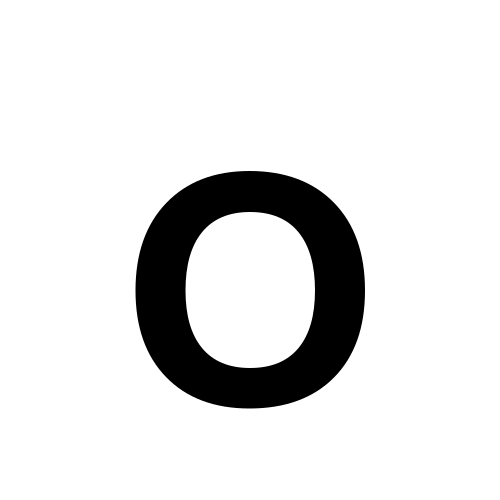

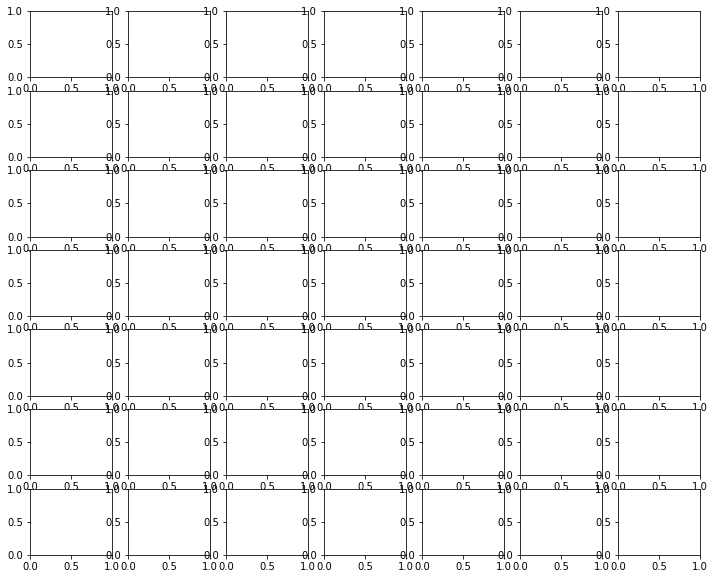

In [17]:
x,y = next(iter(data.train_dl))
pa = ""
fig,axes = plt.subplots(7,7,figsize=(12,10))
for t,p,a in zip(y[0][0,1:],y[1][0,1:],axes.flatten()):
    t = t.item()
    if t == 9: break
    pa = pa + data.vocab[t] + " " + " ".join([str(z.item()*500) for z in p[:len(tool_dict[data.vocab[t]])]]) + " "
    
img = render_path(pa,500,500)
display(SVG(img))


In [13]:
class UpBlock(nn.Module):
    def __init__(self, up_in_c:int,final_div:bool=True, blur:bool=False, leaky:float=None,self_attention:bool=False, **kwargs):
        super().__init__()
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        ni = up_in_c//2
        nf = ni if final_div else ni//2
        self.conv1 = conv_layer(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = conv_layer(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        return self.conv2(self.conv1(up_out))
    
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(62,16)
        self.encoder = nn.Sequential(
            conv2d(1,32,5,1,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,32,5,2,2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
            conv2d(32,64,5,1,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,5,2,2),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU(),
            conv2d(64,64,3,2,1),
            nn.InstanceNorm2d(64,affine=True),
            nn.ReLU())
        
        self.z_mean = nn.Linear(64*16,32)
        self.z_logvar = nn.Linear(64*16,32)
        
        self.z_to_dec = nn.Linear(32+16,128*16)
        
        nf = [128,64,32,16]
        #nf = [2048,1024,512,256,128]
        self.decoder = nn.Sequential(*[UpBlock(f, blur=(False if f != 32 else False)) for f in nf])
        self.final_conv = conv_layer(8, 1, ks=1, use_activ=False)
    
    def forward(self,x,char_class):
        u = self.encoder(x)
        u = u.view(x.shape[0],-1)
        mean, logvar = self.z_mean(u), self.z_logvar(u)
        
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mean
        #if self.training:
        z = z + eps*std
            
        z = torch.cat([z,self.emb(char_class)],dim=1)
        ls = z
        
        z = self.z_to_dec(z)
        z = z.view(x.shape[0],128,4,4)
        
        return torch.sigmoid(self.final_conv(self.decoder(z))), mean, logvar, ls
        
class VAELoss(nn.Module):
    def forward(self, preds, target):
        rec, mean, logvar,_ = preds
        KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        self.kld = KLD / (rec.shape[0] * 64 * 64)
        self.bce = F.binary_cross_entropy(rec.view(rec.shape[0],-1),target.view(target.shape[0],-1))
        return self.bce + self.kld

class VAETrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self,**kwargs):
        self.smoothBCE, self.smoothKLD = SmoothenValue(0.98), SmoothenValue(0.98)
        self.learn.recorder.add_metric_names(["bce","kld"])
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {"last_input": (last_input,last_target), "last_target": last_input}
    
    def on_batch_end(self,**kwargs):
        self.smoothBCE.add_value(self.learn.loss_func.bce.item())
        self.smoothKLD.add_value(self.learn.loss_func.kld.item())
        
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics,[self.smoothBCE.smooth,self.smoothKLD.smooth])

In [14]:
learnAE = Learner(dataAE,VAE(),loss_func=VAELoss(),callback_fns=[VAETrainer])

In [20]:
learnAE.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,bce,kld,time
0,0.528836,#na#,0.521451,0.007384,00:50
1,0.415997,#na#,0.408484,0.007512,00:50
2,0.403723,#na#,0.396438,0.007285,00:50
3,0.401605,#na#,0.394396,0.007208,00:50
4,0.400683,#na#,0.393456,0.007227,00:50


In [21]:
learnAE.save("ae")

In [15]:
learnAE.load("ae");

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAELoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type UpBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
x,y = next(iter(dataAE.train_dl))

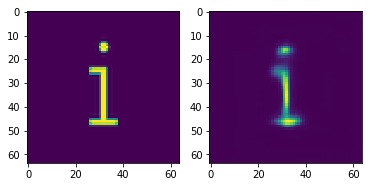

In [17]:
fig, axes = plt.subplots(1,2)
learnAE.model.eval()
rec = learnAE.model(x,y)[0]
axes[0].imshow(x[0].permute(1,2,0).squeeze())
axes[1].imshow(rec[0].permute(1,2,0).squeeze())

In [108]:
ONEOVERSQRT2PI = 1.0 / math.sqrt(2*math.pi)

class MDN(nn.Module):
    """A mixture density network layer
    The input maps to the parameters of a MoG probability distribution, where
    each Gaussian has O dimensions and diagonal covariance.
    Arguments:
        in_features (int): the number of dimensions in the input
        out_features (int): the number of dimensions in the output
        num_gaussians (int): the number of Gaussians per output dimensions
    Input:
        minibatch (BxD): B is the batch size and D is the number of input
            dimensions.
    Output:
        (pi, sigma, mu) (BxG, BxGxO, BxGxO): B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions for each
            Gaussian. Pi is a multinomial distribution of the Gaussians. Sigma
            is the standard deviation of each Gaussian. Mu is the mean of each
            Gaussian.
    """
    def __init__(self, in_features, out_features, num_gaussians):
        super(MDN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_gaussians = num_gaussians
        self.pi = nn.Sequential(nn.Linear(in_features,512),nn.ReLU(inplace=True),nn.Linear(512, out_features*num_gaussians))

        self.sigma = nn.Sequential(nn.Linear(in_features,512),nn.ReLU(inplace=True),nn.Linear(512, out_features*num_gaussians))
        self.mu = nn.Sequential(nn.Linear(in_features,512),nn.ReLU(inplace=True),nn.Linear(512, out_features*num_gaussians))

    def forward(self, minibatch):
        pi = self.pi(minibatch).view(minibatch.shape[0],minibatch.shape[1],self.out_features,self.num_gaussians)
        pi = torch.softmax(pi,dim=3)
        sigma = torch.exp(self.sigma(minibatch))
        sigma = sigma.view(minibatch.shape[0], minibatch.shape[1], self.out_features,self.num_gaussians)
        mu = torch.tanh(self.mu(minibatch))
        mu = mu.view(minibatch.shape[0],minibatch.shape[1], self.out_features, self.num_gaussians)
        return pi, sigma, mu


def gaussian_probability(sigma, mu, target):
    """Returns the probability of `data` given MoG parameters `sigma` and `mu`.
    
    Arguments:
        sigma (BxGxO): The standard deviation of the Gaussians. B is the batch
            size, G is the number of Gaussians, and O is the number of
            dimensions per Gaussian.
        mu (BxGxO): The means of the Gaussians. B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions per Gaussian.
        data (BxI): A batch of data. B is the batch size and I is the number of
            input dimensions.
    Returns:
        probabilities (BxG): The probability of each point in the probability
            of the distribution in the corresponding sigma/mu index.
    """
    target = target.unsqueeze(2).expand_as(sigma)
    ret = ONEOVERSQRT2PI * torch.exp(-0.5 * ((target - mu) / sigma)**2) / sigma
    return torch.prod(ret, 3)


def mdn_loss(pi, sigma, mu, target):
    """Calculates the error, given the MoG parameters and the target
    The loss is the negative log likelihood of the data given the MoG
    parameters.
    """
    ntarget = target.unsqueeze(-1)
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(ntarget))
    #loss = torch.softmax(m.log_prob(ntarget),dim=2)
    loss = torch.sum(loss * pi, dim=3)
    #print((loss > 1).sum())
    loss = -torch.log(loss+1e-8)
    loss = loss[target != -2.0]
    return loss.mean()
#     prob = pi * gaussian_probability(sigma, mu, target)
#     nll = -torch.log(torch.sum(prob, dim=2))
#     return torch.mean(nll)


# def sample(pi, sigma, mu):
#     """Draw samples from a MoG.
#     """
#     categorical = torch.distributions.Categorical(pi[0,0])
#     sel = categorical.sample()
#     dist = torch.distributions.Normal(mu[0,0,sel],sigma[0,0,sel])
#     return dist.sample()

In [186]:
# def sample(pi, sigma, mu):
#     """Draw samples from a MoG.
#     """
#     categorical = torch.distributions.Categorical(pi)
#     pis = list(categorical.sample().data)
#     sample = sigma.data.new(sigma.size(0), sigma.size(2)).normal_()
#     for i, idx in enumerate(pis):
#         sample[i] = sample[i].mul(sigma[i,idx]).add(mu[i,idx])
#     return sample

def sample(pi, sigma, mu):
    """Draw samples from a MoG.
    """
    dist = torch.distributions.Categorical(pi)
    s = dist.sample().cuda()
    mu = torch.gather(mu,3,s.unsqueeze(-1)).squeeze(-1)
    sigma = torch.gather(sigma,3,s.unsqueeze(-1)).squeeze(-1)
    dist_n = torch.distributions.Normal(mu,sigma)
    return dist_n.sample().cuda()

In [187]:
pi = torch.softmax(torch.randn(32,50,4,5),dim=3)
sigma = torch.exp(torch.randn(32,50,4,5))
mu = torch.randn(32,50,4,5)
target = torch.randn(32,50,4)

In [188]:
mdn_loss(pi,sigma,mu,target)

tensor(1.8573)

In [189]:
sample(pi.cuda(),sigma.cuda(),mu.cuda()).shape

torch.Size([32, 50, 4])

In [333]:
class SVGDecoder(nn.Module):
    def __init__(self,num_tokens):
        super().__init__()
        self.token_emb = nn.Embedding(num_tokens,4)
        self.rnn = nn.GRU(4+4+32+16,1024,4,batch_first=True,dropout=0.3)
        self.z_to_hidden = nn.Linear(32+16,1024)
        self.token = nn.Linear(1024,num_tokens)
#         #self.pen = nn.Linear(1024,4)
        self.pen = MDN(1024,4,64)
        
    def get_preds(self, z):
        #z (bsx48)
        hs = self.z_to_hidden(z).unsqueeze(0).expand(4,-1,-1).contiguous()
        tools = [torch.zeros(z.shape[0],1,dtype=torch.long).fill_(8).cuda()]
        pens = [torch.zeros(z.shape[0],1,4).fill_(-2.0).cuda()]
        i = 0
        while i < 200:
            r_in = torch.cat([self.token_emb(tools[-1]),pens[-1],z.unsqueeze(1)],dim=2)
            output, hs = self.rnn(r_in,hs)
            tool = self.token(output)
            pen = self.pen(output)
            pen = sample(*pen)
            tools.append(torch.argmax(tool,dim=2))
            pens.append(pen)
            i += 1
            
        return torch.cat(tools,dim=1), torch.cat(pens,dim=1)
        
    def forward(self, tokens, pen, z):
        tokens = self.token_emb(tokens)
        hs = self.z_to_hidden(z).unsqueeze(0).expand(4,-1,-1).contiguous()
        r_in = torch.cat([tokens,pen,z.unsqueeze(1).expand(-1,tokens.shape[1],-1)],dim=2)
        output, hs = self.rnn(r_in,hs)
        
        tokens = self.token(output)
        #pens = self.pen(output)
        #return tokens, pens
        pi,sigma,mu = self.pen(output)
        
        return tokens, (pi[:,:-1],sigma[:,:-1], mu[:,:-1])

In [206]:
s = SVGDecoder(len(data.vocab)).cuda()

In [208]:
s.get_preds(torch.randn(1,48).cuda())[0].shape

torch.Size([1, 201])

In [337]:
class SVGDecoderLoss(nn.Module):
    def forward(self,preds,target_tokens,target_pen):
        tokens, pen = preds
        mask = target_tokens != 0
        loss_token = F.cross_entropy(tokens.transpose(1,2)[:,:,:-1],target_tokens,reduction="none")[mask].mean()
        #loss_token = 10*F.cross_entropy(tokens.transpose(1,2)[:,:,:-1],target_tokens)
        loss_pen = mdn_loss(*pen,target_pen)
        self.l_t = loss_token.item()
        self.l_p = loss_pen.item()
        with torch.no_grad():
            s = sample(pen[0].detach(),pen[1].detach(),pen[2].detach())
            self.l_mse = F.mse_loss(s,target_pen,reduction="none")[target_pen != -2.0].mean().item()
        return loss_token + loss_pen

class SVGDecoderTrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self,**kwargs):
        self.smoothCE, self.smoothMDN, self.smoothMSE = SmoothenValue(0.98), SmoothenValue(0.98), SmoothenValue(0.98)
        self.learn.recorder.add_metric_names(["ce","mdn", "mse"])
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        learnAE.model.train()
        _,_,_,z = learnAE.model(last_input,last_target[2])
        return {"last_input": (last_target[0],last_target[1],z), "last_target": (last_target[0][:,1:],last_target[1][:,1:])}
    
    def on_batch_end(self,**kwargs):
        self.smoothCE.add_value(self.learn.loss_func.l_t)
        self.smoothMDN.add_value(self.learn.loss_func.l_p)
        self.smoothMSE.add_value(self.learn.loss_func.l_mse)
        
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics,[self.smoothCE.smooth,self.smoothMDN.smooth,self.smoothMSE.smooth])

In [338]:
learnSVG = Learner(data,SVGDecoder(len(data.vocab)),loss_func=SVGDecoderLoss(),callback_fns=[SVGDecoderTrainer])

In [339]:
learnSVG.fit_one_cycle(200,1e-3)

epoch,train_loss,valid_loss,ce,mdn,mse,time
0,2.727683,#na#,1.870030,0.857653,0.922963,00:03
1,1.752846,#na#,1.637137,0.115707,0.481970,00:03
2,1.056420,#na#,1.505853,-0.449435,0.242721,00:03
3,0.693892,#na#,1.413582,-0.719691,0.143359,00:03
4,0.493277,#na#,1.353777,-0.860500,0.094533,00:03
5,0.368601,#na#,1.305869,-0.937269,0.068610,00:03
6,0.285424,#na#,1.267794,-0.982370,0.054214,00:03
7,0.227744,#na#,1.235920,-1.008176,0.045818,00:03
8,0.184264,#na#,1.207425,-1.023161,0.041355,00:03
9,0.137538,#na#,1.178468,-1.040930,0.038900,00:03


In [340]:
learnSVG.save("svg_0")

In [211]:
learnSVG.load("svg_0");

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SVGDecoderLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SVGDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type MDN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [341]:
def get_pred_path(x,labels):
    z = learnAE.model(x,labels)[3]
    tools, pens = learnSVG.model.get_preds(z)
    out = []
    for t,p in zip(tools[0,1:-1],pens[0,1:-1]):
        t = data.vocab[t]
        out.append(t)
        out.append(" ".join([str(int(np.rint(500*n.item()))) for n in p[:len(tool_dict[t])]]))
    return " ".join(out)

In [347]:
x,y = next(iter(data.train_dl))
labels = y[2]

In [353]:
p = get_pred_path(x[[0]],labels[[0]])
p = p[:p.find("z")+1]
p

'M 123 379 l 190 -281 l -161 0 l 6 -50 l -2 29 l -1 25 l -171 0 l -157 0 l -1 0 l 166 0 l 0 0 z'

In [362]:
def path_from_tensors(tools,pens):
    i = 0
    p = ""
    for t,pen in zip(tools[i,1:],pens[i,1:]):
        tool = data.vocab[t]
        if tool == "END": break
        pen = [str(int(np.rint(x.item()))) for x in pen*500]
        p = p + tool + " " + " ".join(pen[:len(tool_dict[tool])]) + " "
    return p

In [348]:
[(data.vocab[t],[int(np.rint(x.item())) for x in pen*500]) for t,pen in zip(y[0][0],y[1][0])]

[('START', [-1000, -1000, -1000, -1000]),
 ('M', [119, 380, -1000, -1000]),
 ('l', [191, -277, -1000, -1000]),
 ('l', [-142, 0, -1000, -1000]),
 ('l', [6, -46, -1000, -1000]),
 ('l', [214, 0, -1000, -1000]),
 ('l', [-2, 21, -1000, -1000]),
 ('l', [-192, 276, -1000, -1000]),
 ('l', [157, 0, -1000, -1000]),
 ('l', [-7, 46, -1000, -1000]),
 ('l', [-228, 0, -1000, -1000]),
 ('z', [-1000, -1000, -1000, -1000]),
 ('END', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000, -1000]),
 ('PAD', [-1000, -1000, -1000,

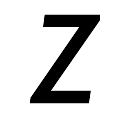

In [365]:
render_path_wand(path_from_tensors(y[0],y[1]),500,500)

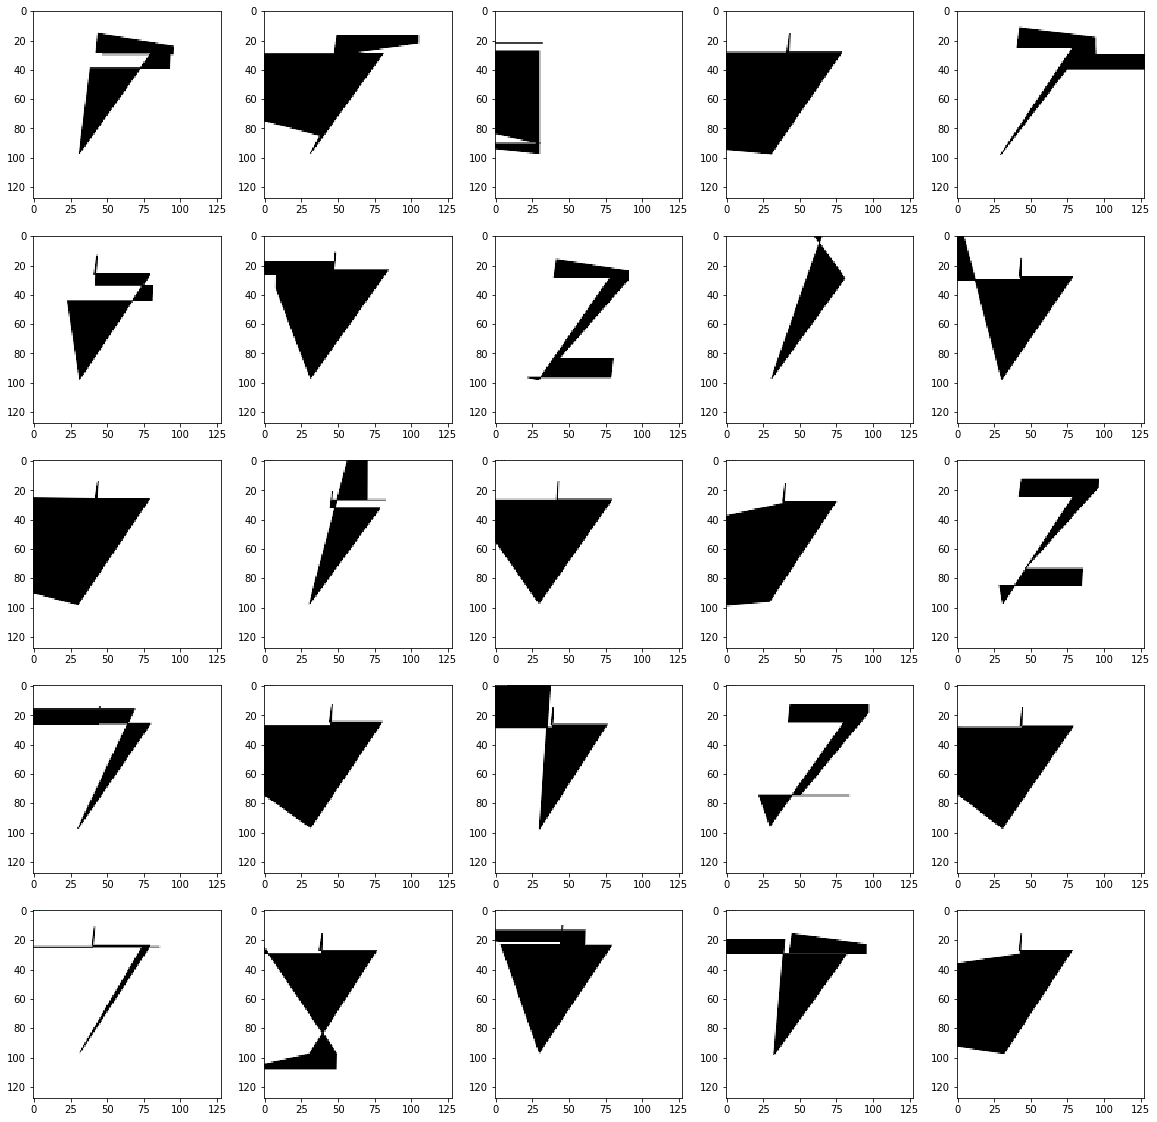

In [357]:
fig,axes = plt.subplots(5,5,figsize=(20,20))
for ax in axes.flatten():
    p = get_pred_path(x[[0]],labels[[0]])
    p = p[:p.find("z")+1]
    img = render_path_wand(p,500,500)
    ax.imshow(img)

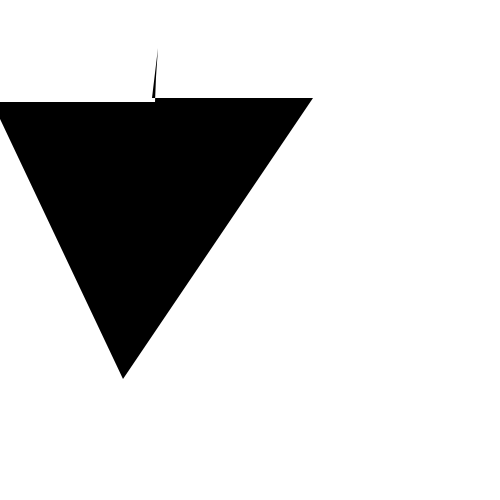

In [354]:
display(SVG(render_path(p,500,500)))

In [229]:
y[1][0]*100

tensor([[-200.0000, -200.0000, -200.0000, -200.0000],
        [  32.4500,   75.9000, -200.0000, -200.0000],
        [  -5.6000,   -4.8000,   -5.6000,  -13.4000],
        [   0.0000,   -7.0000,    3.2500,  -12.4500],
        [   9.6500,   -7.8500, -200.0000, -200.0000],
        [  -6.6000,   -4.7000,   -6.6000,  -13.3000],
        [   0.0000,   -5.8000,    2.7500,  -10.2500],
        [   7.6500,   -6.9000, -200.0000, -200.0000],
        [  11.0000,   -2.4500, -200.0000, -200.0000],
        [   8.2000,   -0.0000,   13.3500,    4.2500],
        [   5.1500,   11.5500, -200.0000, -200.0000],
        [   0.0000,   11.6000,  -11.1000,   16.7000],
        [   4.7000,    2.2000,    7.3000,    5.8500],
        [   2.6000,    9.9500, -200.0000, -200.0000],
        [   0.0000,    6.9000,   -3.0500,   12.1500],
        [  -8.5000,    8.1000, -200.0000, -200.0000],
        [ -12.5500,    2.8500, -200.0000, -200.0000],
        [  -9.7000,   -0.0000,  -15.3000,   -4.8000],
        [-200.0000, -200.000

In [49]:
[data.vocab[t.item()] for t in y[0][0]]

['START',
 'M',
 'q',
 'q',
 't',
 't',
 'q',
 'l',
 'h',
 'l',
 'h',
 'l',
 'q',
 't',
 'q',
 'z',
 'M',
 'q',
 't',
 'q',
 't',
 'q',
 't',
 't',
 'l',
 'q',
 't',
 'q',
 'z',
 'END',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']